In [1]:
import insightface
import os
import onnxruntime
import onnx
import cv2
import threading
import cv2
import numpy
import numpy as np
from deepface import DeepFace
import matplotlib.pyplot as plt

In [2]:
provider = [onnxruntime.get_available_providers()[0]]
reference_face_position = 0
similar_face_distance = 0.85

In [3]:
swapper = insightface.model_zoo.get_model("inswapper_128.onnx", providers=provider)
lock = threading.Lock()
face_annalyser = None

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
inswapper-shape: [1, 3, 128, 128]


In [4]:
def annalyser():
    global face_annalyser
    with lock:
        if face_annalyser is None:
            face_annalyser = insightface.app.FaceAnalysis(name='buffalo_l', providers=provider)
            face_annalyser.prepare(ctx_id=0)
    return face_annalyser

In [5]:
def get_many_faces(frame):
    try:
        return annalyser().get(frame)
    except ValueError:
        return None

In [6]:
def get_one_face(frame, position = 0):
    many_faces = get_many_faces(frame)
    if many_faces:
        try:
            return many_faces[position]
        except IndexError:
            return many_faces[-1]
    return None

In [7]:
def find_similar_face(frame, reference_face):
    many_faces = get_many_faces(frame)
    if many_faces:
        for face in many_faces:
            if hasattr(face, 'normed_embedding') and hasattr(reference_face, 'normed_embedding'):
                distance = numpy.sum(numpy.square(face.normed_embedding - reference_face.normed_embedding))
                if distance < similar_face_distance:
                    return face
    return None

In [8]:
def process_frame(source_face, reference_face, temp_frame):
    target_face = find_similar_face(temp_frame, reference_face)
    if target_face:
        try:
            temp_frame = swapper.get(temp_frame, target_face, source_face, paste_back=True)
        except:
            print("Face not found in the image provided")
#             Exception handinling for wrong face
    return temp_frame

In [9]:
def swap(new_face,image): 
    source_face = get_one_face(new_face)
    target_frame = image
    reference_face = get_one_face(target_frame, reference_face_position)
    result = process_frame(source_face, reference_face, target_frame)
    plt.imshow(result[:,:,::-1])
    plt.show()
    return result

Sample 1


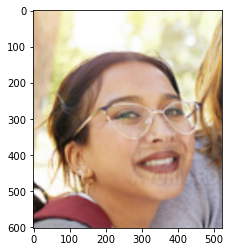

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/bhaskar/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/bhaskar/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/bhaskar/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/bhaskar/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/bhaskar/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

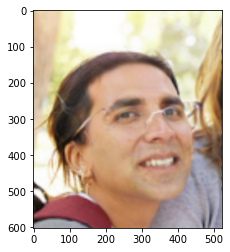

Sample 2


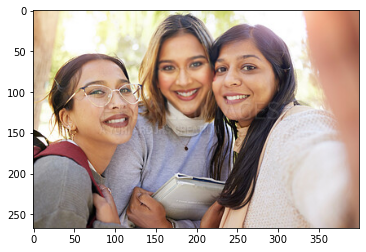

array([[[128, 179, 219],
        [124, 172, 214],
        [119, 166, 210],
        ...,
        [ 96, 123, 187],
        [ 95, 122, 186],
        [ 95, 122, 186]],

       [[130, 181, 221],
        [126, 174, 216],
        [122, 169, 213],
        ...,
        [ 96, 123, 187],
        [ 95, 122, 186],
        [ 95, 122, 186]],

       [[133, 182, 222],
        [129, 177, 219],
        [124, 171, 215],
        ...,
        [ 96, 123, 187],
        [ 95, 122, 186],
        [ 94, 121, 185]],

       ...,

       [[ 77,  89,  95],
        [ 75,  89,  95],
        [ 71,  87,  94],
        ...,
        [ 95, 111, 148],
        [100, 116, 153],
        [100, 118, 155]],

       [[ 76,  88,  94],
        [ 74,  88,  94],
        [ 72,  85,  93],
        ...,
        [ 95, 111, 148],
        [100, 116, 153],
        [100, 118, 155]],

       [[ 75,  87,  93],
        [ 73,  87,  93],
        [ 71,  84,  92],
        ...,
        [ 95, 111, 148],
        [100, 116, 153],
        [100, 118, 155]]

In [10]:
# Program manual testing
print("Sample 1")
plt.imshow(cv2.imread("static/test01.jpg")[:,:,::-1])
plt.show()
swap(cv2.imread("static/men/0.jpg"),cv2.imread("static/test01.jpg"))
print("Sample 2")
swap(cv2.imread("static/test01.png"),cv2.imread("static/faces.jpg"))

In [11]:
# Function to return face from an image in a required aspect ration
def face_image_resize(img, w,h):
    detected_faces = DeepFace.analyze(img, actions = ["gender"], enforce_detection=False)
    detected = False
    detected_face = img
    if len(detected_faces) > 0:
        for temp_img in detected_faces[:1]:
            x = max(temp_img["region"]["x"] - 50, 0)
            y = max(temp_img["region"]["y"] - 50, 0)
            w = temp_img["region"]["w"] + 100
            h = temp_img["region"]["h"] + 100
            detected_face = img[y:y+h, x:x+w]
            detected = True
    new_image = cv2.resize(detected_face, (w, h))
    return new_image

In [16]:
def replace_face(path, images=[]):
    # Loading the image to be edited
    img = cv2.imread(path)
    # Idntifying all the faces and the gender of the person using deepface
    obj = DeepFace.analyze(img, actions = ["gender"])
    # Printing out the gender along with the faces detected
    temp_obj = []
    i = 0
    test = ""
    face = ""
    for temp_img in obj:
        sub_path = ""
        if len(images) > i:
            sub_path = images[i]
        elif len(images) == i:
            i = 0
            sub_path = f'static/{i}.jpg'
        else:
            sub_path = f'static/{i}.jpg'
        xo = temp_img["region"]["x"]
        yo = temp_img["region"]["y"]
        wo = temp_img["region"]["w"]
        ho = temp_img["region"]["h"]
        x = max(temp_img["region"]["x"] - 50, 0)
        y = max(temp_img["region"]["y"] - 50, 0)
        w = temp_img["region"]["w"] + 100
        h = temp_img["region"]["h"] + 100
        print("Gender : " + temp_img["dominant_gender"])
        print("Face : ")
        test = img[y:y+h, x:x+w]
        plt.imshow(img[y:y+h, x:x+w][:,:,::-1])
        plt.show()
        if bool(int(input("Change face 0/1? "))):
            print(f'using {sub_path}')
            face = face_image_resize(cv2.imread(sub_path), w,h)
            new_face_image = swap(face, test)
            img[y:y+h, x:x+w] = new_face_image
            i = i + 1
        print("")
    cv2.imwrite("output.jpg", img)
    print("image saved")
    plt.imshow(img[:,:,::-1])
    plt.show()

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Gender : Woman
Face : 


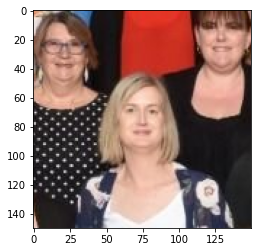


Gender : Man
Face : 


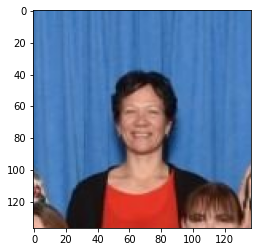


Gender : Woman
Face : 


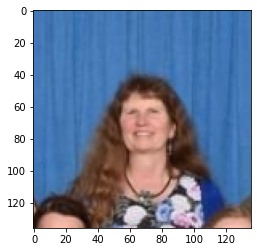


Gender : Woman
Face : 


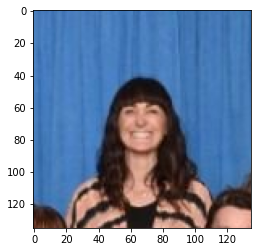


Gender : Woman
Face : 


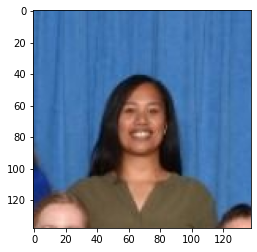


Gender : Woman
Face : 


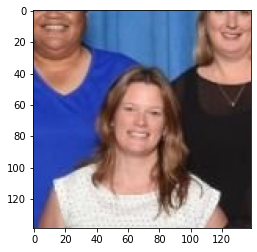


Gender : Man
Face : 


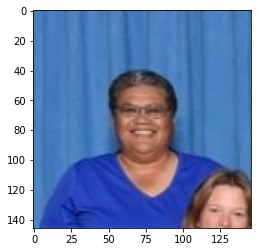


Gender : Man
Face : 


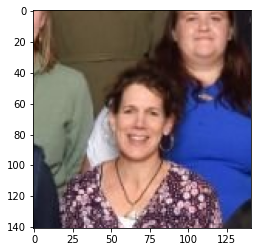


Gender : Woman
Face : 


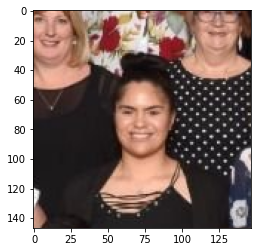


Gender : Woman
Face : 


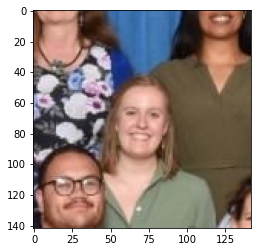


Gender : Woman
Face : 


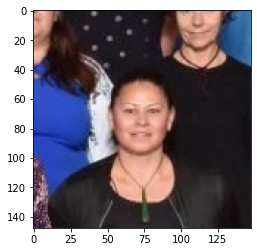


Gender : Man
Face : 


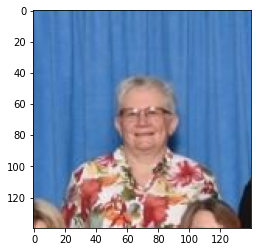


Gender : Woman
Face : 


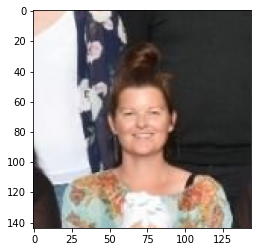


Gender : Woman
Face : 


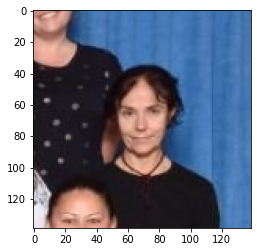


Gender : Man
Face : 


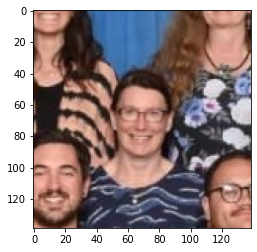


Gender : Man
Face : 


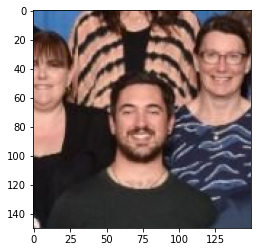


Gender : Man
Face : 


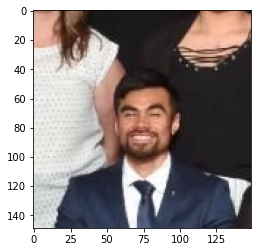


Gender : Woman
Face : 


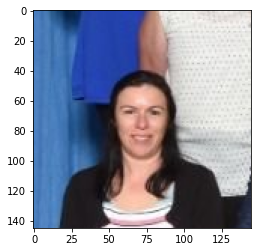


Gender : Woman
Face : 


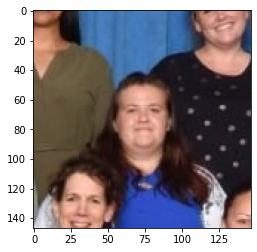


Gender : Woman
Face : 


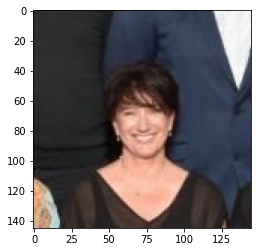


Gender : Woman
Face : 


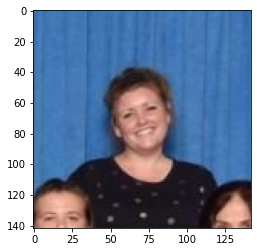


Gender : Woman
Face : 


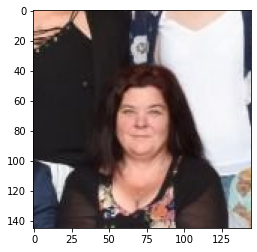


Gender : Man
Face : 


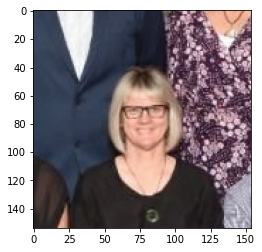


Gender : Man
Face : 


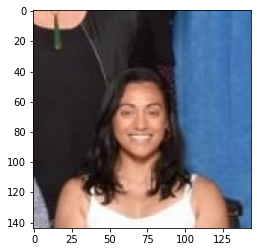


Gender : Man
Face : 


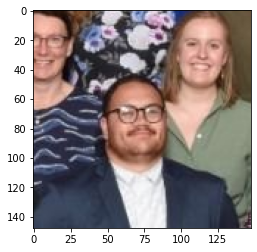


Gender : Man
Face : 


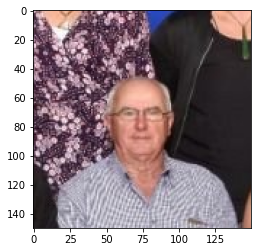


image saved


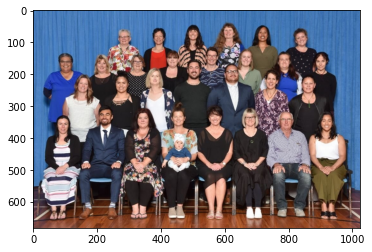

In [17]:
replace_face("static/college/test.jpg", [])